In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import xarray as xr
print(f"Running on PyMC v{pm.__version__}")

df = pd.read_csv(r'../../Downloads/datasets-master/tips.csv')
df

Running on PyMC v3.11.2


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


<AxesSubplot:xlabel='total_bill', ylabel='tip'>

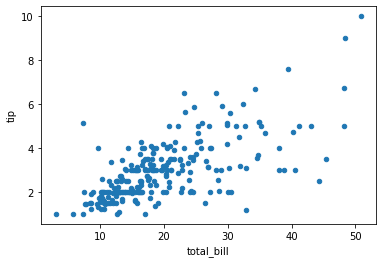

In [2]:
df.plot(kind='scatter', x='total_bill', y='tip')

In [3]:
sex = df.groupby('sex').ngroup()
df.drop(columns=['sex'], inplace=True)
df['sex'] = sex
df

,total_bill,tip,smoker,day,time,size,sex
0,16.99,1.01,No,Sun,Dinner,2,0
1,10.34,1.66,No,Sun,Dinner,3,1
2,21.01,3.50,No,Sun,Dinner,3,1
3,23.68,3.31,No,Sun,Dinner,2,1
4,24.59,3.61,No,Sun,Dinner,4,0
...,...,...,...,...,...,...,...
239,29.03,5.92,No,Sat,Dinner,3,1
240,27.18,2.00,Yes,Sat,Dinner,2,0
241,22.67,2.00,Yes,Sat,Dinner,2,1
242,17.82,1.75,No,Sat,Dinner,2,1


In [4]:
smoker = df.groupby('smoker').ngroup()
df.drop(columns=['smoker'], inplace=True)
df['smoker'] = smoker
df

,total_bill,tip,day,time,size,sex,smoker
0,16.99,1.01,Sun,Dinner,2,0,0
1,10.34,1.66,Sun,Dinner,3,1,0
2,21.01,3.50,Sun,Dinner,3,1,0
3,23.68,3.31,Sun,Dinner,2,1,0
4,24.59,3.61,Sun,Dinner,4,0,0
...,...,...,...,...,...,...,...
239,29.03,5.92,Sat,Dinner,3,1,0
240,27.18,2.00,Sat,Dinner,2,0,1
241,22.67,2.00,Sat,Dinner,2,1,1
242,17.82,1.75,Sat,Dinner,2,1,0


In [5]:
df['time'].unique()

array(['Dinner', 'Lunch'], dtype=object)

In [6]:
dinner = df.groupby('time').ngroup()
df.drop(columns=['time'], inplace=True)
df['dinner'] = dinner
df

,total_bill,tip,day,size,sex,smoker,dinner
0,16.99,1.01,Sun,2,0,0,0
1,10.34,1.66,Sun,3,1,0,0
2,21.01,3.50,Sun,3,1,0,0
3,23.68,3.31,Sun,2,1,0,0
4,24.59,3.61,Sun,4,0,0,0
...,...,...,...,...,...,...,...
239,29.03,5.92,Sat,3,1,0,0
240,27.18,2.00,Sat,2,0,1,0
241,22.67,2.00,Sat,2,1,1,0
242,17.82,1.75,Sat,2,1,0,0


In [7]:
df['day'].unique()

array(['Sun', 'Sat', 'Thur', 'Fri'], dtype=object)

In [8]:
df['Sun'] = df['day'] == 'Sun'
df['Sat'] = df['day'] == 'Sat'
df['Thur'] = df['day'] == 'Thur'
df['Fri'] = df['day'] == 'Fri'

df['sun'] = df.groupby('Sun').ngroup()
df['sat'] = df.groupby('Sat').ngroup()
df['thur'] = df.groupby('Thur').ngroup()
df['fri'] = df.groupby('Fri').ngroup()

df.drop(columns=['Sun', 'Sat', 'Thur', 'Fri', 'day'], inplace=True)
df

,total_bill,tip,size,sex,smoker,dinner,sun,sat,thur,fri
0,16.99,1.01,2,0,0,0,1,0,0,0
1,10.34,1.66,3,1,0,0,1,0,0,0
2,21.01,3.50,3,1,0,0,1,0,0,0
3,23.68,3.31,2,1,0,0,1,0,0,0
4,24.59,3.61,4,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
239,29.03,5.92,3,1,0,0,0,1,0,0
240,27.18,2.00,2,0,1,0,0,1,0,0
241,22.67,2.00,2,1,1,0,0,1,0,0
242,17.82,1.75,2,1,0,0,0,1,0,0


In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
     df.drop(columns=['tip']), df['tip'], test_size=0.20, random_state=42)

In [10]:
X_train.columns

Index(['total_bill', 'size', 'sex', 'smoker', 'dinner', 'sun', 'sat', 'thur',
       'fri'],
      dtype='object')

In [11]:
with pm.Model() as model:    
    total_bill = pm.Data('total_bill', X_train.total_bill)
    size = pm.Data('size', X_train.size)
    sex = pm.Data('sex', X_train.sex)
    smoker = pm.Data('smoker', X_train.smoker)
    dinner = pm.Data('dinner', X_train.dinner)
    sun = pm.Data('sunday', X_train.sun)
    sat = pm.Data('saturday', X_train.sat)
    thur = pm.Data('thursday', X_train.thur)
    fri = pm.Data('friday', X_train.fri)
    
    y = pm.Data('y',y_train)
    
    a = pm.Normal('Intercept', mu=0, sigma=5)
    b_size = pm.Normal('beta_size', mu=0, sigma=5)
    b_tb = pm.Normal('beta_totalbill', mu=0, sigma=5)
    b_sex = pm.Normal('beta_sex', mu=0, sigma=5)
    b_smoker = pm.Normal('beta_smoker', mu=0, sigma=5)
    b_dinner = pm.Normal('beta_dinner', mu=0, sigma=5)
    b_sun = pm.Normal('beta_sun', mu=0, sigma=5)
    b_sat = pm.Normal('beta_sat', mu=0, sigma=5)
    b_thur = pm.Normal('beta_thur', mu=0, sigma=5)
    b_fri = pm.Normal('beta_fri', mu=0, sigma=5)
    
    sigma = pm.HalfNormal('sigma', sd=10)
    
    mu = pm.Deterministic('mu', a + b_size*size + b_tb * total_bill + b_sex * sex +
                          b_smoker * smoker + b_dinner*dinner +
                          b_sun * sun + b_sat * sat + 
                          b_thur*thur + b_fri*fri)
    
    yhat = pm.Normal('yhat', mu=mu, sd=sigma, observed=y)
    
    trace = pm.sample(tune=4000, draws=500, cores=2, target_accept=.99, return_inferencedata=True, model=model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta_fri, beta_thur, beta_sat, beta_sun, beta_dinner, beta_smoker, beta_sex, beta_totalbill, beta_size, Intercept]


/usr/local/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/usr/local/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 4_000 tune and 500 draw iterations (8_000 + 1_000 draws total) took 1177 seconds.


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'beta_size'}>,
        <AxesSubplot:title={'center':'beta_size'}>],
       [<AxesSubplot:title={'center':'beta_totalbill'}>,
        <AxesSubplot:title={'center':'beta_totalbill'}>],
       [<AxesSubplot:title={'center':'beta_sex'}>,
        <AxesSubplot:title={'center':'beta_sex'}>],
       [<AxesSubplot:title={'center':'beta_smoker'}>,
        <AxesSubplot:title={'center':'beta_smoker'}>],
       [<AxesSubplot:title={'center':'beta_dinner'}>,
        <AxesSubplot:title={'center':'beta_dinner'}>],
       [<AxesSubplot:title={'center':'beta_sun'}>,
        <AxesSubplot:title={'center':'beta_sun'}>],
       [<AxesSubplot:title={'center':'beta_sat'}>,
        <AxesSubplot:title={'center':'beta_sat'}>],
       [<AxesSubplot:title={'center':'beta_thur'}>,
        <AxesSubplot:title={'center':'beta_thur'}>],
       [<AxesSubplot:title={'center':'beta_

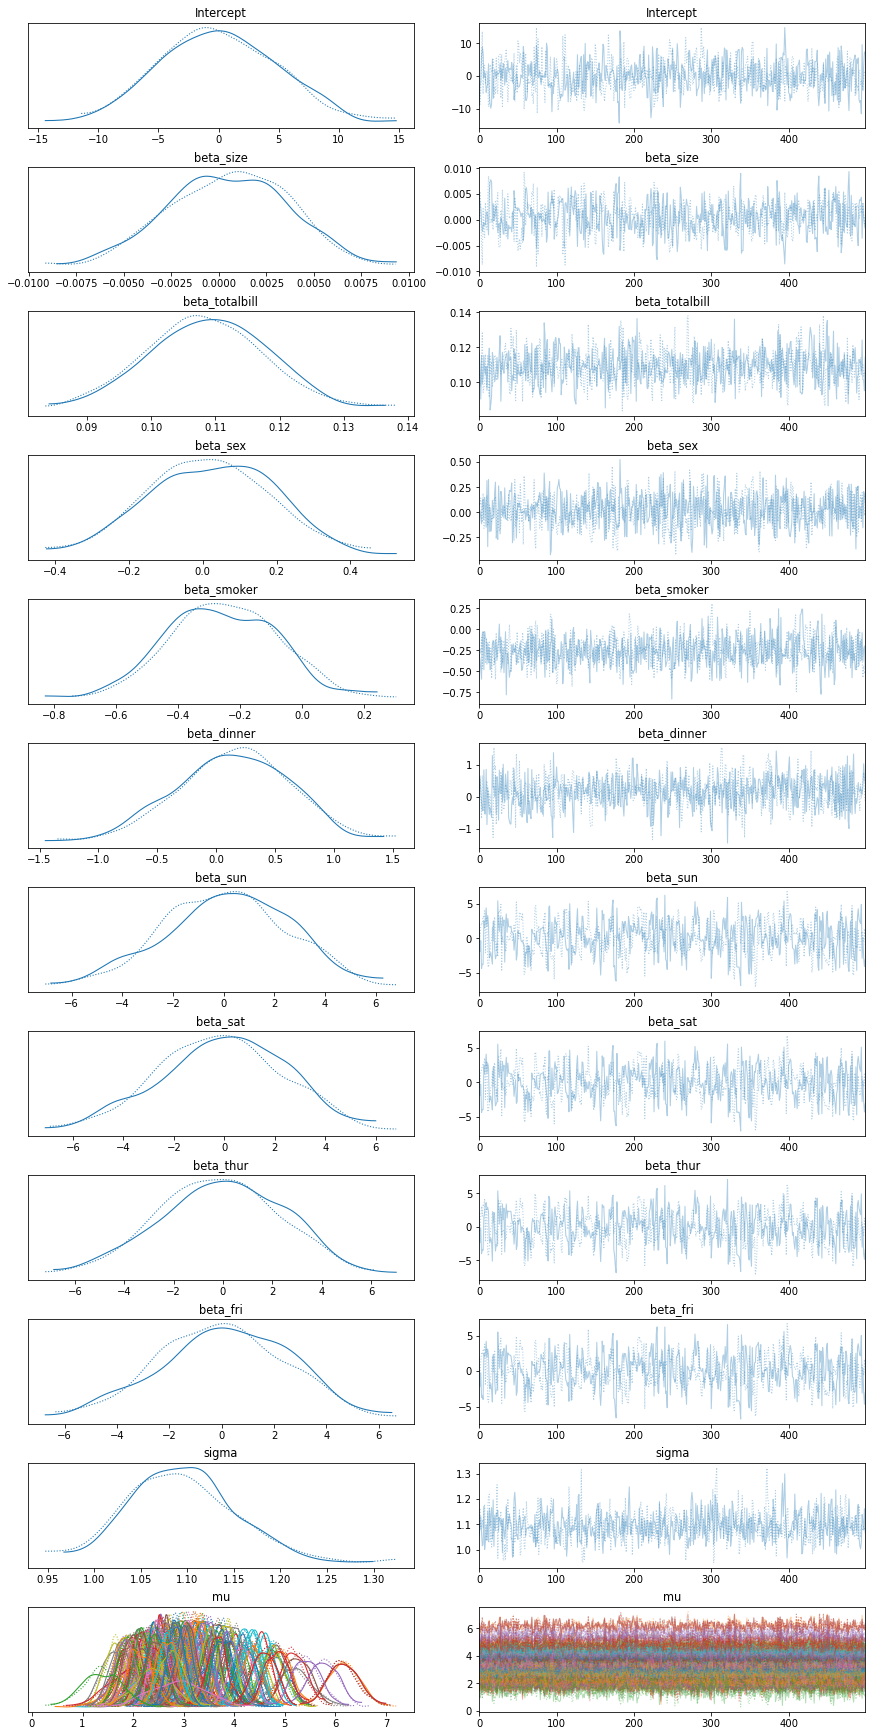

In [12]:
az.plot_trace(trace)

In [13]:
results = pm.summary(trace)
results

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,0.037,4.810,-8.215,9.173,0.183,0.156,692.0,475.0,692.0,788.0,1.01
beta_size,0.001,0.003,-0.005,0.006,0.000,0.000,575.0,488.0,583.0,616.0,1.00
beta_totalbill,0.109,0.010,0.090,0.126,0.000,0.000,1078.0,1038.0,1090.0,695.0,1.00
beta_sex,0.020,0.165,-0.263,0.343,0.005,0.005,1045.0,495.0,1056.0,682.0,1.00
beta_smoker,-0.255,0.176,-0.583,0.055,0.006,0.004,976.0,976.0,978.0,622.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...
mu[190],2.858,0.168,2.540,3.158,0.005,0.004,938.0,938.0,992.0,675.0,1.00
mu[191],2.678,0.197,2.266,3.017,0.006,0.004,1105.0,1088.0,1109.0,736.0,1.00
mu[192],1.387,0.387,0.658,2.106,0.013,0.009,917.0,865.0,923.0,714.0,1.01
mu[193],4.598,0.228,4.192,5.029,0.007,0.005,1075.0,1075.0,1071.0,795.0,1.00


In [14]:
pm.set_data({"total_bill": X_test.total_bill, 'size': X_test.size, 'sex': X_test.sex, 
            'smoker': X_test.smoker, 'dinner': X_test.smoker, 'sunday': X_test.sun, 
            'saturday': X_test.sat, 'thursday': X_test.thur, 'friday': X_test.fri}, model=model)
# Generate posterior samples.
ppc_test = pm.sample_posterior_predictive(trace, model=model, samples=2000)

In [46]:
pred = ppc_test['yhat'].mean(0)

# Using Posterior Distribution

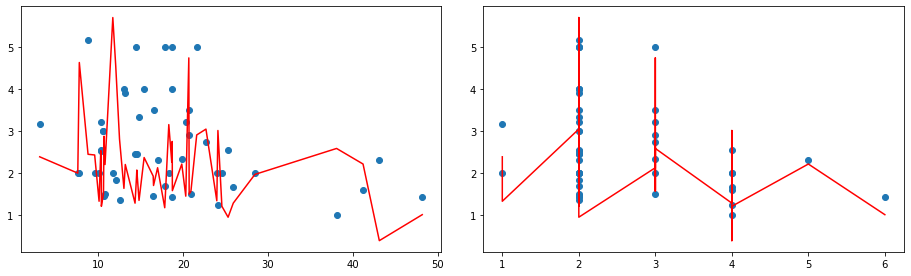

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))
fig.tight_layout()

X_test['pred'] = pred
X_test.sort_values(by='total_bill', inplace=True)
ax[0].scatter(X_test.total_bill, y_test)
ax[0].plot(X_test.total_bill, X_test.pred, c='r')

X_test.sort_values(by='size', inplace=True)
ax[1].scatter(X_test['size'].values, y_test)
ax[1].plot(X_test['size'].values, X_test.pred, c='r')

X_test.reset_index(inplace=True)

# Using Mean of Beta Distributions

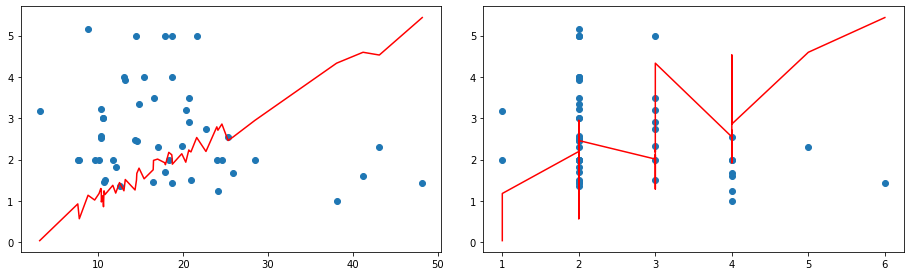

In [50]:
X_test.drop(columns=['pred'], inplace=True)
pred = results['mean']['Intercept'] + results['mean']['beta_size'] * X_test['size'] + results['mean']['beta_totalbill'] * X_test.total_bill + results['mean']['beta_sex'] * X_test.sex + results['mean']['beta_smoker'] * X_test.smoker + results['mean']['beta_dinner'] * X_test.dinner + results['mean']['beta_sun'] * X_test.sun + results['mean']['beta_sat'] * X_test.sat + results['mean']['beta_thur'] * X_test.thur + results['mean']['beta_fri'] * X_test.fri

X_test['pred'] = pred

fig, ax = plt.subplots(1, 2, figsize=(13, 4))
fig.tight_layout()


X_test.sort_values(by='total_bill', inplace=True)
ax[0].scatter(X_test.total_bill, y_test)
ax[0].plot(X_test.total_bill, X_test.pred, c='r')

X_test.sort_values(by='size', inplace=True)
ax[1].scatter(X_test['size'].values, y_test)
ax[1].plot(X_test['size'].values, X_test.pred, c='r')

# fit from mean of betas